In [ ]:
!pip install transformers
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=7802f8dd3dbd02bf4520dbd139f0f3830fe0afc2952c0de9877d823a3a29d6ea
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [ ]:
#!pip uninstall numba
#!pip install 'numba>=0.46'
#!pip install umap-learn
#!pip install -U numba

#!pip install -e git+https://github.com/lmcinnes/umap.git@0.4dev#egg=umap5
#!pip install /content/src/umap5

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch
from transformers import HerbertTokenizer, RobertaModel, AutoTokenizer, BertModel

import umap
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

In [ ]:
def get_data_set(labels, df):
  idxs = []
  for label in labels:
    idxs_for_label, = np.where(df['Label'] == label)
    for idx in idxs_for_label:
      idxs.append(idx)

  new_df = df.iloc[idxs]
  new_df = new_df.sample(frac = 1).reset_index(drop=True)
  return new_df

In [ ]:
def print_classes(df):
  authors = {}
  y = df['Label']
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]
  num_classes = len(df['Label'].unique())
  for label in range(0, num_classes):
    i, = np.where(y == label)
    authors['{}'.format(df['Author-short'][i[0]])] = label

  return authors

In [ ]:
def make_tokens(df, model):
  model_name, tokenizer, model = model
  tokens = {}

  df_tokens = pd.DataFrame()
  tokenize = lambda sent: tokenizer.encode_plus(sent, max_length=512, padding='max_length', truncation=True)
  df_tokens['tokens'] = df['Text'].map(tokenize)
  df_tokens['input_ids'] = df_tokens['tokens'].map(lambda t: t['input_ids'] )
  df_tokens['token_type_ids'] = df_tokens['tokens'].map(lambda t: t['token_type_ids'] )
  df_tokens['attention_mask'] = df_tokens['tokens'].map(lambda t: t['attention_mask'] )


  input_ids = np.stack(df_tokens['input_ids'])
  token_type_ids = np.stack(df_tokens['token_type_ids'])
  attention_mask = np.stack(df_tokens['attention_mask'])

  inputs = {"input_ids":torch.tensor(input_ids),"token_type_ids":torch.tensor(token_type_ids),"attention_mask":torch.tensor(attention_mask)}

  return df_tokens, inputs


In [ ]:
df_tokens, inputs = make_tokens(df_raw, herbert)

In [ ]:
outputs = model(**inputs)

In [ ]:
#dzielenie tokenów na 9 porcji
X_stack = []
embedded = {}
model_name, tokenizer, model = herbert

for idx in tqdm(range(0,400)):
  x = 0

  for i in range(0,9):

    y = x+100
    if(i>7):
      y = 512

    input_ids = np.stack(df_tokens["input_ids"].iloc[idx:idx+1])
    token_type_ids = np.stack(df_tokens["token_type_ids"].iloc[idx:idx+1])
    attention_mask = np.stack(df_tokens["attention_mask"].loc[idx:idx+1])

    input_ids = np.array([input_ids[0][x:y]])
    token_type_ids = np.array([token_type_ids[0][x:y]])
    attention_mask = np.array([attention_mask[0][x:y]])

    x = x + 60

    inputs = {"input_ids":torch.tensor(input_ids),"token_type_ids":torch.tensor(token_type_ids),"attention_mask":torch.tensor(attention_mask)}

    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])
    embedded[idx,i] = X_single_poem[0], df_raw['Label'][idx]


  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['embedding', 'label'])



In [ ]:
def make_embedding(df, model):

  X_stack = []
  model_name, tokenizer, model = model
  embedded = {}
  tokens = {}
  num_idxs = df.shape[0]
  for idx in tqdm(range(0,num_idxs)):
    single_poem_input = df['Text'][idx]
    inputs = tokenizer.batch_encode_plus([single_poem_input], max_length = 512, padding="longest", add_special_tokens=True, return_tensors="pt",)
    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])

    embedded[idx] = X_single_poem[0], df['Label'][idx]

  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['embedding', 'label'])

  return df_embedded

In [ ]:
def get_X_y(df):

  X = np.stack(df['embedding'])
  y = df['Label']

  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

  print(X.shape)

  return X, y, X_train, X_test, y_train, y_test,  X_val, y_val

In [ ]:
def normalize_data(X):

  X_normalized = np.zeros((X.shape[0],X.shape[1]))

  for idx in range(0,400):
    X_normalized[idx,:] = (X[idx,:] - np.mean(X[idx,:]))/ np.std(X[idx,:])

  return X_normalized

In [ ]:
#herbert_large = ["Herbert-large", HerbertTokenizer.from_pretrained("allegro/herbert-large-cased"), RobertaModel.from_pretrained("allegro/herbert-large-cased")]
#herbert_base = ["Herbert-base", HerbertTokenizer.from_pretrained("allegro/herbert-base-cased"), RobertaModel.from_pretrained("allegro/herbert-base-cased")]
herbert_klej = ["Herbert-klej", HerbertTokenizer.from_pretrained("allegro/herbert-klej-cased-tokenizer-v1"), RobertaModel.from_pretrained("allegro/herbert-klej-cased-v1")]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMTokenizer'. 
The class this function is called from is 'HerbertTokenizer'.


In [ ]:
os.mkdir("figs")

In [ ]:
df_raw = pd.read_csv('/content/wiersze_do_BERT_Herbert_Miłosz.csv', ";")
df_raw .columns

<ipython-input-14-856413025014>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_raw = pd.read_csv('/content/wiersze_do_BERT_Herbert_Miłosz.csv', ";")


Index(['Author', 'Author-short', 'Title', 'Text', 'From', 'Note', 'Words',
       'Label', 'Gender', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [ ]:
df_raw  = df_raw .drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'])
df_raw.shape

(450, 9)

In [ ]:
df_raw.iloc[400:]

In [ ]:
df_raw = df_raw.drop(df_raw.index[400:])
df_raw

In [ ]:
df_orginal = pd.DataFrame
df_orginal = pd.concat([df_raw['Text'],df_raw['Label'],df_raw['Author-short']], axis=1)
df_orginal

,Text,Label,Author-short
0,"Nie wierz Fortunie, co siedzisz wysoko; Miej n...",0.0,J. Kochanowki
1,W twardej kamiennej wieży i za troistemi Drzwi...,0.0,J. Kochanowki
2,"Wieczna sromota i nienagrodzona Szkoda, Polaku...",0.0,J. Kochanowki
3,"Królewno lutnie złotej i rymów pociesznych, Oc...",0.0,J. Kochanowki
4,"Nie porzucaj nadzieje, Jakoć sie kolwiek dziej...",0.0,J. Kochanowki
...,...,...,...
395,Wielki Odkrywco Wyobraźni na rybiookich wspart...,7.0,E. Lipska
396,Odchodzisz ode mnie jak lato. I powracasz do m...,7.0,E. Lipska
397,I jak tu popełnić samobójstwo droga pani kiedy...,7.0,E. Lipska
398,W oczy mi patrzysz wciąż tak samo jak w tysiąc...,7.0,E. Lipska


In [ ]:
df_women = df_raw[200:].reset_index(drop=True)
df_men = df_raw[:200].reset_index(drop=True)
#df_women = df_women.sample(frac = 1).reset_index(drop=True)
#df_men = df_men.sample(frac = 1).reset_index(drop=True)

In [ ]:
embedding = make_embedding(df_orginal, herbert_klej)
df_orginal = pd.concat([df_orginal, embedding['embedding']], axis=1)
df_orginal

 13%|█▎        | 51/400 [00:04<00:31, 11.20it/s]


KeyboardInterrupt: ignored

In [ ]:
embedding_women = make_embedding(df_women, herbert_klej)
df_women = pd.concat([df_women, embedding_women['embedding']], axis=1)
df_women

In [ ]:
embedding_men = make_embedding(df_men, herbert_klej)
df_men = pd.concat([df_men, embedding_men['embedding']], axis=1)
df_men

In [ ]:
df = df_women
data_type = 'women'
fontsize = 16

In [ ]:
classes = print_classes(df)
classes

{'W. Szymborska': 0,
 'H. Poświatowska': 1,
 'M. P. Jasnorzewska': 2,
 'E. Lipska': 3}

In [ ]:
X, y, _,_,_,_,_,_ = get_X_y(df)

(200, 768)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

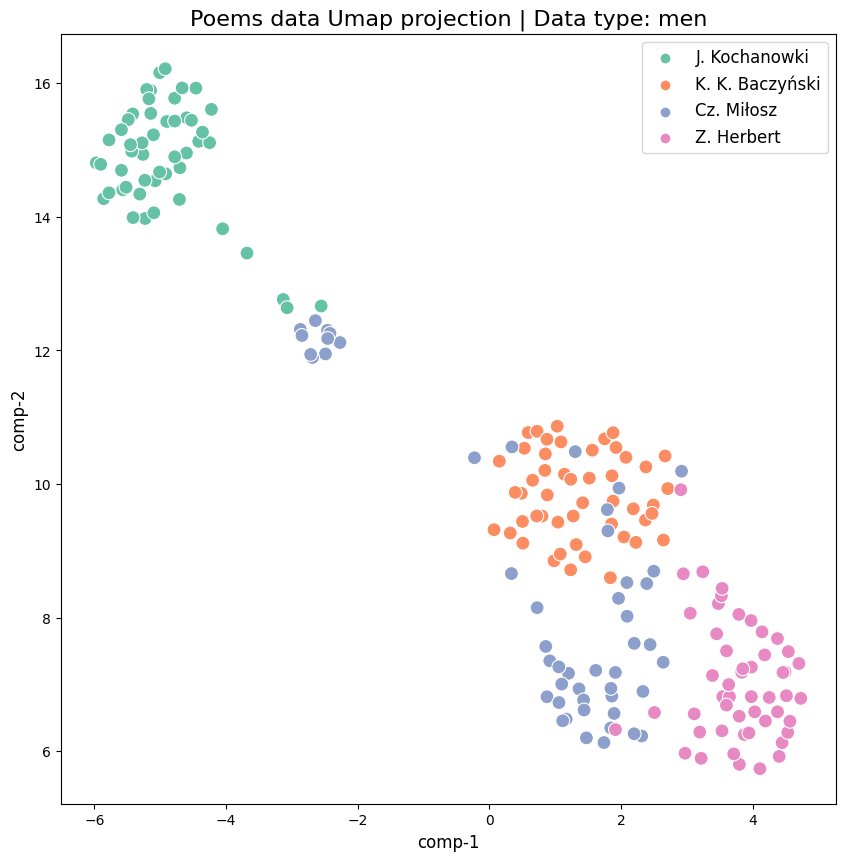

In [ ]:
# Umap
df_umap = pd.DataFrame()
df_umap["y"] = df['Author-short']
num_classes = len(classes)
n_neighbors = [30]
min_distnces= [0.3]
n_components=2
metric='euclidean'

for n_neighbor in n_neighbors:
  for min_dist in min_distnces:
    reducer = umap.UMAP(n_neighbors=n_neighbor,
            min_dist=min_dist,
            n_components=n_components,
            metric=metric)
    scaled_X = StandardScaler().fit_transform(X)
    embed = reducer.fit_transform(scaled_X)

    df_umap["comp-1"] = embed[:,0]
    df_umap["comp-2"] = embed[:,1]

    plt.figure(figsize = (10,10))

    sns.scatterplot(x="comp-1", y="comp-2", hue=df_umap.y.tolist(),
                   palette=sns.color_palette("Set2", num_classes),
                   data=df_umap, s=100)#.set(title="Poems data Umap projection | Data type: {}".format(data_type, n_neighbor, min_dist))

    plt.legend(fontsize=12)
    plt.xlabel("comp-1",fontsize=12);
    plt.ylabel("comp-2",fontsize=12);
    plt.title("Poems data Umap projection | Data type: {}".format(data_type, n_neighbor, min_dist),fontsize=fontsize)

plt.savefig('/content/figs/umap_{}.png'.format(data_type))
files.download('/content/figs/umap_{}.png'.format(data_type))

In [ ]:
# 3D Umap

num_classes = len(classes)
n_neighbors = [20]
min_distnces= [0.6]
n_components=3
metric='euclidean'
for n_neighbor in n_neighbors:
  for min_dist in min_distnces:
    reducer = umap.UMAP(n_neighbors=n_neighbor,
                min_dist=min_dist,
                n_components=n_components,
                metric=metric)
    scaled_X = StandardScaler().fit_transform(X)
    embed = reducer.fit_transform(scaled_X)

    Xax = embed[:,0]
    Yax = embed[:,1]
    Zax = embed[:,2]


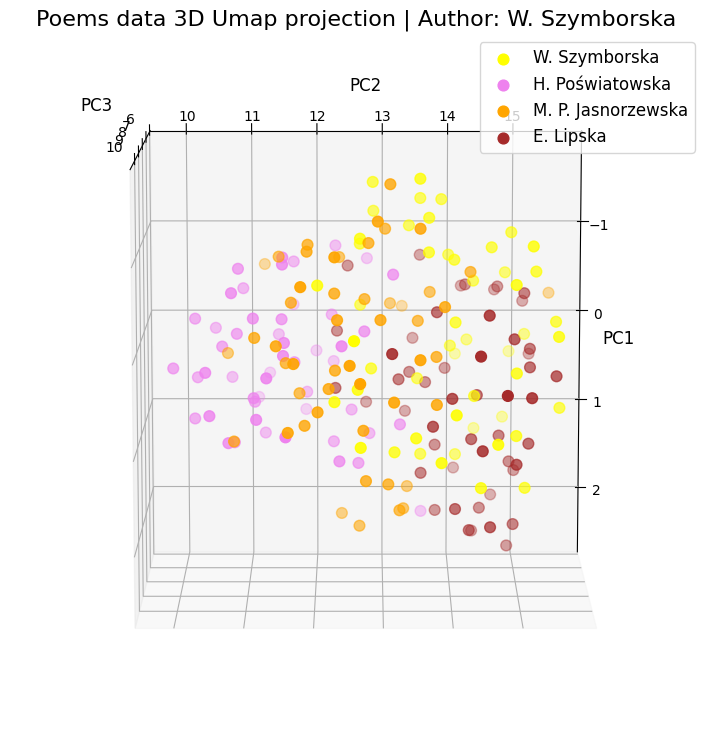

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
alpha = [100] #np.arange(0,360,20)
beta = [0] #np.arange(0,360,20)
name = 'W. Szymborska'
for a in alpha:
  for b in beta:
    #cdict = {0:'cyan',1:'red',2:'blue',3:'green',4:'yellow',5:'violet',6:'orange',7:'brown'}
    #label = {0:'J. Kochanowki',1:'K. K. Baczyński',2:'Cz. Miłosz',3:'Z. Herbert',4:'W. Szymborska',5:'H. Poświatowska',6:'M. P. Jasnorzewska',7:'E. Lipska'}
    cdict = {0:'yellow',1:'violet',2:'orange',3:'brown'}
    label = {0:'W. Szymborska',1:'H. Poświatowska',2:'M. P. Jasnorzewska',3:'E. Lipska'}
    #cdict = {0:'cyan',1:'red',2:'blue',3:'green'}
    #label = {0:'J. Kochanowki',1:'K. K. Baczyński',2:'Cz. Miłosz',3:'Z. Herbert'}
    fig = plt.figure(figsize=(14,9))
    ax = fig.add_subplot(111,
                    projection='3d')
    for l in np.unique(y):
      ix=np.where(y==l)
      ax.scatter(Xax[ix],
                  Yax[ix],
                  Zax[ix],
                  c=cdict[l],
                  s=60,
                label=label[l])

    ax.set_xlabel("PC1",
                  fontsize=12)
    ax.set_ylabel("PC2",
                  fontsize=12)
    ax.set_zlabel("PC3",
                  fontsize=12)
    ax.view_init(a, b)
    ax.legend(fontsize=12)
    plt.title("Poems data 3D Umap projection | Author: {}".format(name), fontsize=fontsize)
    plt.show()

    fig.savefig('/content/figs/umap_3D_{}_{}.png'.format(data_type, name))
    files.download('/content/figs/umap_3D_{}_{}.png'.format(data_type, name))


In [ ]:
# 3D PCA
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)
pca = PCA(n_components=3)
pca.fit(scaled_X)
pca_X = pca.transform(scaled_X)
Xax = pca_X[:,0]
Yax = pca_X[:,1]
Zax = pca_X[:,2]

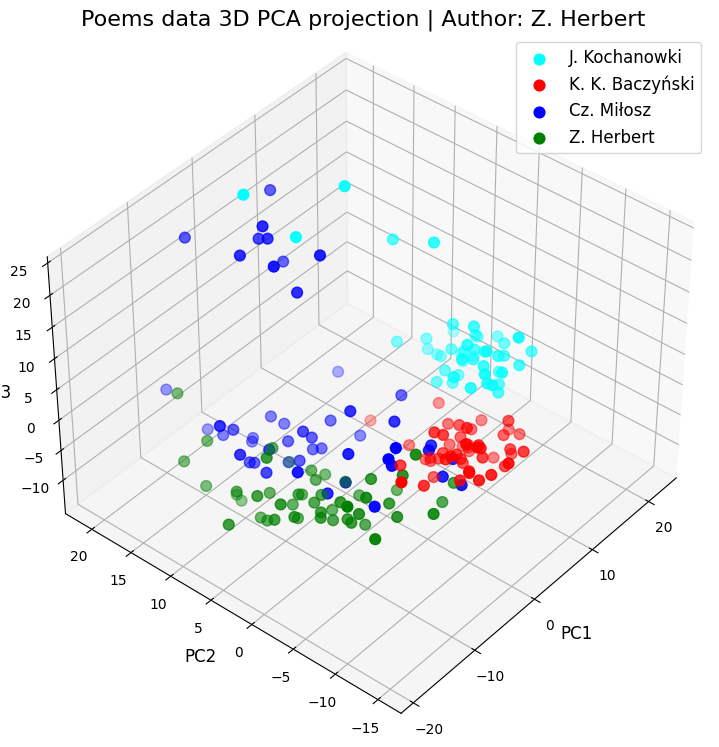

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
alpha = [40] #np.arange(0,360,20)
beta = [220] #np.arange(0,360,20)
name = 'Z. Herbert'
for a in alpha:
  for b in beta:
    #cdict = {0:'cyan',1:'red',2:'blue',3:'green',4:'yellow',5:'violet',6:'orange',7:'brown'}
    #label = {0:'J. Kochanowki',1:'K. K. Baczyński',2:'Cz. Miłosz',3:'Z. Herbert',4:'W. Szymborska',5:'H. Poświatowska',6:'M. P. Jasnorzewska',7:'E. Lipska'}
    #cdict = {0:'yellow',1:'violet',2:'orange',3:'brown'}
    #label = {0:'W. Szymborska',1:'H. Poświatowska',2:'M. P. Jasnorzewska',3:'E. Lipska'}
    cdict = {0:'cyan',1:'red',2:'blue',3:'green'}
    label = {0:'J. Kochanowki',1:'K. K. Baczyński',2:'Cz. Miłosz',3:'Z. Herbert'}
    fig = plt.figure(figsize=(14,9))
    ax = fig.add_subplot(111,
                        projection='3d')

    for l in np.unique(y):
      ix=np.where(y==l)
      ax.scatter(Xax[ix],
                  Yax[ix],
                  Zax[ix],
                  c=cdict[l],
                  s=60,
                label=label[l])

    ax.set_xlabel("PC1",
                  fontsize=12)
    ax.set_ylabel("PC2",
                  fontsize=12)
    ax.set_zlabel("PC3",
                  fontsize=12)

    ax.view_init(a, b)
    ax.legend(fontsize=12)
    plt.title("Poems data 3D PCA projection | Author: {}".format(name), fontsize=fontsize)
    plt.show()

    fig.savefig('/content/figs/pca_3D_{}_{}.png'.format(data_type, name))
    files.download('/content/figs/pca_3D_{}_{}.png'.format(data_type, name))

In [ ]:
X_normalized = normalize_data(X)
print(X_normalized)

[[ 1.05532527  0.19188614 -0.13789551 ... -0.07131817 -0.2730391
   1.33986557]
 [ 1.40730369 -0.42062372 -0.4124279  ...  0.1331702  -0.54625511
   0.87863487]
 [ 1.51277947 -0.08471828 -0.77416885 ... -0.07770964 -0.72016168
   1.21667027]
 ...
 [ 0.44821423 -0.28577188  0.23266374 ...  0.99474651 -0.12464992
   0.31398657]
 [-0.05449888  0.05189031 -0.3240748  ...  0.49282715 -0.09743513
   0.88313985]
 [ 0.24576756 -0.5983128  -0.36969915 ...  0.28846005 -0.71431112
   0.713332  ]]


In [ ]:
distance_euclidean_X_normalized = np.zeros((X_normalized.shape[0], X_normalized.shape[0]))
distance_cosinus_X_normalized = np.zeros((X_normalized.shape[0], X_normalized.shape[0]))

for i in range(0,distance_euclidean_X_normalized.shape[0]):
  x_normalized_i = X_normalized[i,:]
  for j in range(0,distance_euclidean_X_normalized.shape[0]):
    x_normalized_j = X_normalized[j,:]
    distance_euclidean_X_normalized[i,j] = np.sqrt(np.sum( np.abs(x_normalized_i - x_normalized_j)**2))
    distance_cosinus_X_normalized[i,j] = np.dot(x_normalized_i, x_normalized_j)/1024


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

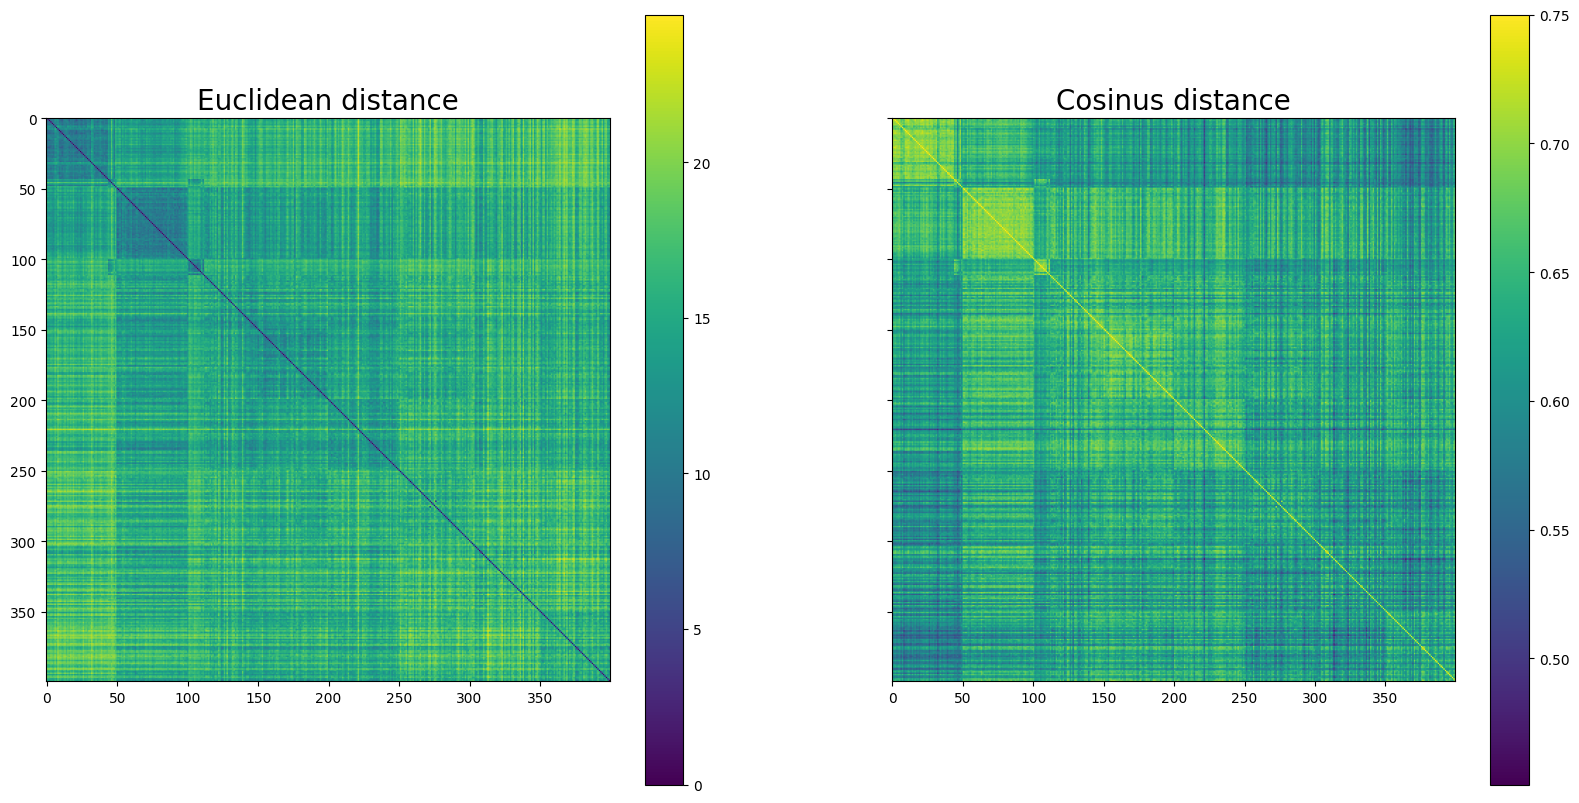

In [ ]:
distances = {"Euclidean distance":distance_euclidean_X_normalized, "Cosinus distance":distance_cosinus_X_normalized}
data_type = "all"
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey='row')
im = ax[0].imshow(distance_euclidean_X_normalized)
ax[0].set_title('Euclidean distance', fontsize=20)
im2 = ax[1].imshow(distance_cosinus_X_normalized)
ax[1].set_title('Cosinus distance', fontsize=20)
fig.colorbar(im, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

fig.savefig('/content/figs/euclidean_and_cosinus.png')
files.download('/content/figs/euclidean_and_cosinus.png')


In [ ]:
fig2, axes = plt.subplots(1, 2, figsize=(20,10), sharey='row')

  for i, (key, cm) in enumerate(cms.items()):

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title("{} | Model: Neural Network | Data type: {} | Acc: {}".format(key, data_type, round(score_avrg,2)))
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')


  fig2.text(0.40, 0.1, 'Predicted label', ha='left')
  plt.subplots_adjust(wspace=0.40, hspace=0.1)

  fig2.colorbar(disp.im_, ax=axes)
  plt.show()

  plt.gcf().set_size_inches(10, 5)
  fig2.savefig('/content/figs/avrg_neural_network_{}_scheme_{}_fraction_{}.png'.format(data_type, scheme, fraction), dpi=200)
  files.download('/content/figs/avrg_neural_network_{}_scheme_{}_fraction_{}.png'.format(data_type, scheme, fraction))

Text(0.5, 1.0, 'Distance between vectors | data type: men')

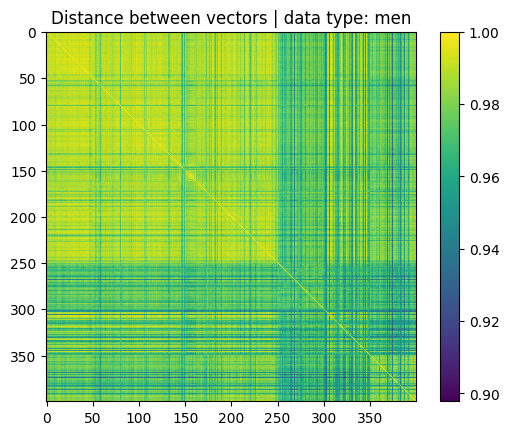

In [ ]:
plt.imshow(distance_cosinus_X_normalized)
plt.colorbar()
plt.title('Distance between vectors | data type: men')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

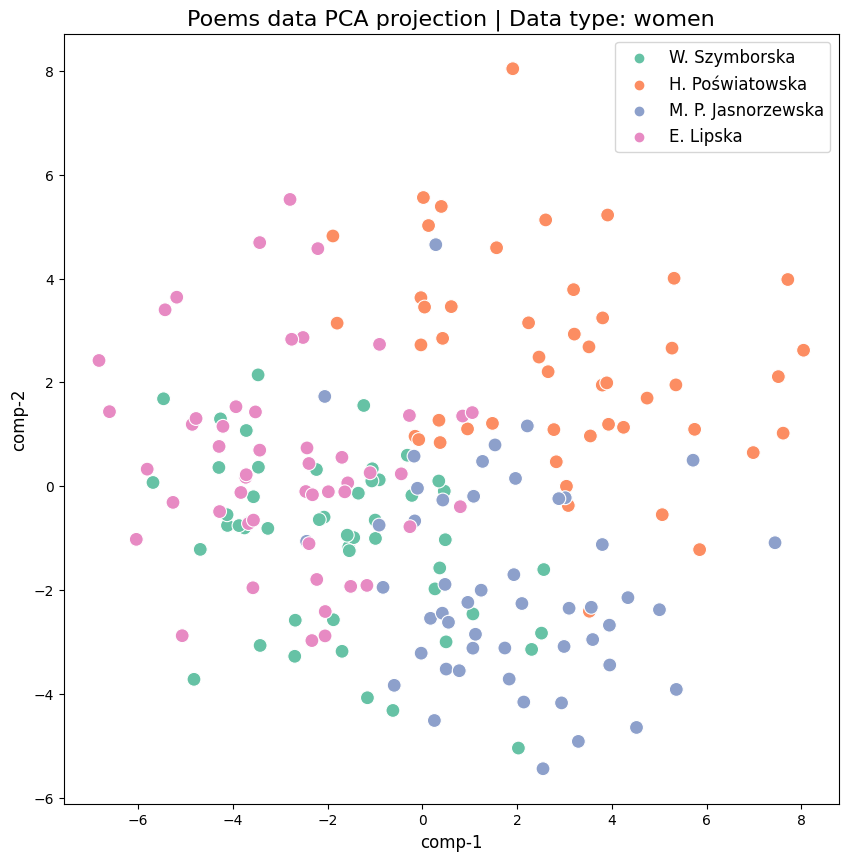

In [ ]:
df_pca = pd.DataFrame()
df_pca["y"] = df['Author-short']
num_classes = len(classes)

plt.figure(figsize = (10,10))
pca = PCA(n_components=2).fit_transform(X, y)

df_pca["comp-1"] = pca[:,0]
df_pca["comp-2"] = pca[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_pca.y.tolist(),
                palette=sns.color_palette("Set2", num_classes),
                data=df_pca, s=100).set(title="Poems data PCA projection | Data type: {}".format(data_type))

plt.legend(fontsize=12)
plt.xlabel("comp-1",fontsize=12);
plt.ylabel("comp-2",fontsize=12);
plt.title("Poems data PCA projection | Data type: {}".format(data_type, n_neighbor, min_dist),fontsize=fontsize)

plt.savefig('/content/figs/pca_{}.png'.format(data_type))
files.download('/content/figs/pca_{}.png'.format(data_type))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

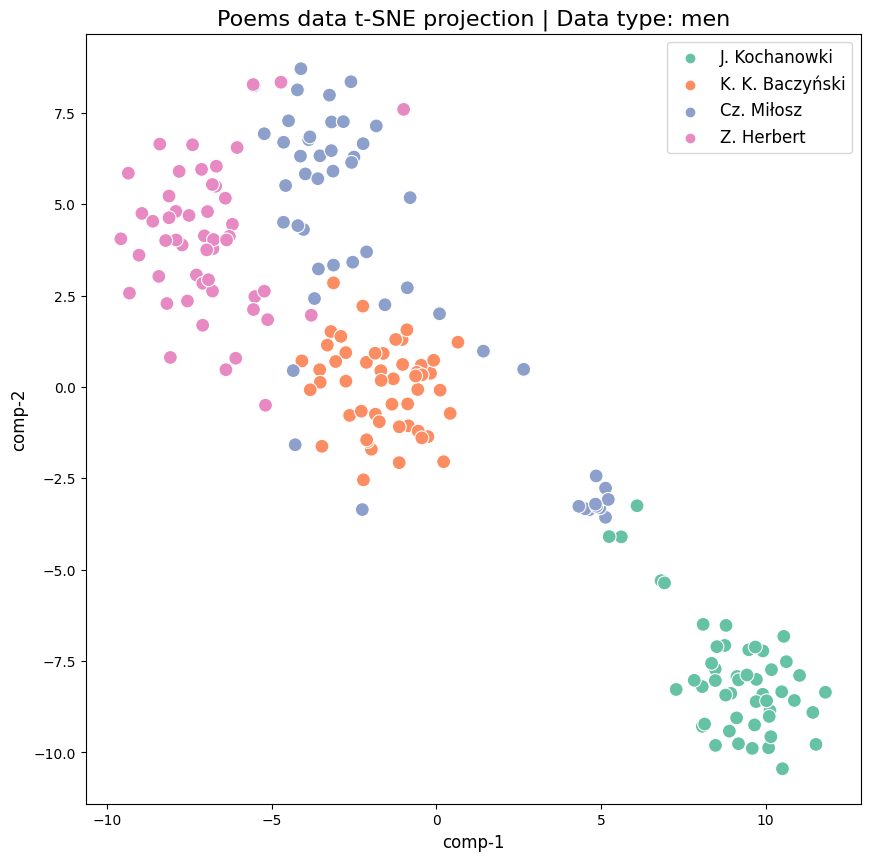

In [ ]:
df_tsne = pd.DataFrame()
df_tsne["y"] = df['Author-short']
num_classes = len(classes)

perps = [35]

for perp in perps:

  plt.figure(figsize = (10,10))
  z = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=perp).fit_transform(X, y)

  df_tsne["comp-1{}".format(perp)] = z[:,0]
  df_tsne["comp-2{}".format(perp)] = z[:,1]

  sns.scatterplot(x="comp-1{}".format(perp), y="comp-2{}".format(perp), hue=df_tsne.y.tolist(),
                palette=sns.color_palette("Set2", num_classes),
                data=df_tsne, s=100).set(title="Poems data t-SNE projection | perplexity: {} | Data type: {}".format(perp, data_type))

  plt.legend(fontsize=12)
  plt.xlabel("comp-1",fontsize=12);
  plt.ylabel("comp-2",fontsize=12);
  plt.title("Poems data t-SNE projection | Data type: {}".format(data_type),fontsize=fontsize)

  plt.savefig('/content/figs/tsne_{}_{}_perplexity.png'.format(data_type, perp))
  files.download('/content/figs/tsne_{}_{}_perplexity.png'.format(data_type, perp))